# Bricks and Board Code Challenge

## The Problem

I am in an open field with an endless supply of bricks. My hobby is stacking bricks up in equally-spaced columns of random heights.

I choose the number of columns randomly. It could be 10, or 27, or 63,972,152. I'm a patient guy and I like columns of bricks.

Each time, when I'm done, I lay a wooden board on top of the columns of bricks. I have access to a huge variety of board lengths, so I always choose one that starts exactly above the top of the first column, and stretches to exactly above the top of the last column, regardless of its angle.

It doesn't always touch the tops of those columns, of course. I chose the column heights randomly. Maybe on some occasions it rests on those, but in other cases it comes to rest on bricks anywhere in between them. It all depends on the height of the columns and where gravity dictates the board will sit. But in any case, these bricks are rough enough that the board never slides off, even at severe slopes.

Your job is to figure out, given the number of bricks in each column, the slope and y-intercept of my board.

Columns of bricks are provided in an array, where the array index is "x" and the value is "y".

## Forget The High School Line Formula Stuff?

Me too. Here's a quick refresher:

A straight line is defined by the formula y = mx + b:

* **x:** the column number, starting from 0
* **y:** the height of the board, in bricks, at that column
* **m:** the slope of the board, or "rise over run": take two points the board is touching, x1,y1 and x2,y2, and the slope is (y2 - y1) / (x2 - x1).
* **b:** y-intercept: how high the board is from the ground, in bricks, at column 0

> _Important Note:_ For simplicity, let's ignore the fact that any angled board will have a slightly varying height over the width of a stack of bricks. The board's height (y) when it's touching a brick is equal to the number of bricks beneath it.

## Here's an example

`[2, 14, 8, 94, 300, 210, 200, 99, 14, 12]`

Laying a board on top of this, it comes to rest on x=4 y=300, and x=6 y=200. ("Not 300 and 210?!" Some of you are thinking? Nope, if it rested on 210, the slope would be too severe that it would fall BELOW the top of the 200 stack. For real, check the math. This problem isn't as simple as it sounds.)

Slope is rise `(y2 - y1)` divided by run `(x2 - x1)`. So: `(200 - 300) / (6 - 4) = -50`.

y-intercept can then be found by plugging the slope into the y=mx+b line equation for either of those resting points above. I'll pick x=6 y=200:

```
200 = -50 * 6 + b
200 = -300 + b
b = 200 - -300
b = 500
```

So with those stacks, slope is **-50** and y-intercept is **500**.

Write me a function that outputs those two variables given any input array. No gravity-defying boards!

## We'll start with some boilerplate code to generate data and charts

No need to edit this, but we'll use it later.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import json

# Function to generate an array of random integers
def generate_random_array(data_length):
    return np.random.randint(0, 100, data_length)

# Function to plot the data and the line
def plot_data_with_line(arr, slope, y_intercept, cursors = None):
    x = np.arange(len(arr))
    y = arr
    
    plt.scatter(x, y, color='red', label='Brick Column Tops')
    if cursors is not None:
        line_x = np.arange(cursors[0], cursors[1] + 1)
    else:
        line_x = x
    line_y = slope * line_x + y_intercept
    plt.plot(line_x, line_y, color='blue', label='Board')

    if cursors is not None:
        plt.axvline(x=cursors[0], color='green', linestyle='--', label='Cursor L')
        plt.text(cursors[0], plt.ylim()[0], 'L', color='green', verticalalignment='bottom', horizontalalignment='right')
        plt.axvline(x=cursors[1], color='green', linestyle='--', label='Cursor R')
        plt.text(cursors[1], plt.ylim()[0], 'R', color='green', verticalalignment='bottom', horizontalalignment='right')

    plt.xlabel('Brick Column')
    plt.ylabel('Brick Height')
    plt.title('Brick Tops and Board')
    plt.show()

## Now it's your turn!

There's a code block below where you'll click and write your solution in Python. Not familiar with Python? No problem! Click CodeWhisperer -> Start CodeWhisperer:

![Start CodeWhiperer](http://i.tomfro.st/7Epnpy.png)

You can create a free Amazon Q sign-in if you don't have one. Click again, and you can see the shortcuts. I recommend clicking "Resume Auto-Suggestions":

![Resume Auto-Suggestions](http://i.tomfro.st/ZziCkh.png)

## Write your code here! The starter code runs, but isn't a real solution.

In [15]:
# Function to calculate the slope and y-intercept
# Solution concept:
#
# The center of gravity of the board is the middle, so one way to restate the
# problem is to find the board position with the lowest possible middle point,
# given that it touches at least one point on the left half and at least one
# point on the right half, with all other points below.
#
# This solution initializes the board with its middle touching the middle
# column of bricks (or, for an even number of columns, spanning the center two
# columns of bricks), because this is the lowest point that the middle could
# ever possibly be. We then employ a middle-out strategy: We have two X-axis
# cursors, a left-moving cursor and a right-moving cursor, both initialized to
# start at the middle.
#
# We begin a loop. On each loop, we move each cursor one column "out" (left
# moves left, right moved right).
#
# Is the left cursor's column above the board?
# - NO: Run the same check on the right cursor.
# - YES: Recalculate the board's slope and y-intercept so it touches the point at
#   the left cursor, and remains touching whatever point it was touching on the
#   right side. Lifting up the left side of the board naturally lowers the part
#   of the board to the right of the right touchpoint, so we need to iterate
#   through the columns between the right touchpoint and the right cursor.
#   If we find a column that is now above the board, we recalculate the board
#   again to make it touch the top of this column.
#
# Did the right touchpoint of the board have to change?
# - NO: This loop iteration is now complete
# - YES: We've now raised the right side of the board, causing it to pivot on
#   the left touchpoint. The board may now fall below one of the columns between
#   the left touchpoint and the left cursor. Step through these columns as
#   described above. (We can skip this if the left side changed in the last step)
#
# Once the loop has completed, the current slope and y-intercept is the answer.
def calculate_slope_intercept(arr, debug_mode = False):
    if len(arr) < 1:
        raise ValueError("Array must have at least one element")

    LEFT = 0
    RIGHT = 1
    STEP = [-1, 1]

    def get_line(x1, x2):
        # If the Xes are the same, it's a horizontal line at Y
        if x1 == x2: return 0, arr[x1]
        slope = (arr[x1] - arr[x2]) / (x1 - x2)
        y_intercept = arr[x1] - slope * x1
        return slope, y_intercept

    # This is a middle-out algorithm. Find the middle of the board, and
    # initialize a left-moving cursor and a right-moving cursor there.
    # These cursors point to the same columns if there's an odd number
    # of columns, or to the two adjacent middle columns when it's even.
    #
    # Right now, these are the only two brick columns we've "seen", so we
    # consider these the touch points and calculate the line that passes
    # through them. The line is horizontal if there's just one middle column.
    midpoint = int(len(arr) / 2)
    cursors = [midpoint - 1, midpoint] if len(arr) % 2 == 0 else [math.floor(midpoint), math.ceil(midpoint)]
    touches = [cursors[0], cursors[1]]
    slope, y_intercept = get_line(touches[0], touches[1])
    if debug_mode: print(f"Starting with {len(arr)} columns, midpoint {midpoint}, cursors {cursors}")
    if debug_mode: plot_data_with_line(arr, slope, y_intercept, cursors)

    def point_beneath_line(x, slope, y_intercept):
        line_height = slope * x + y_intercept
        return arr[x] <= line_height

    def test_side(side, scan_from_touch = False):
        nonlocal slope, y_intercept, touches
        orig_touch = touches[side]
        if scan_from_touch:
            # We need to scan every point between this side's touch and
            # the cursor. When we find a point over the line, it becomes
            # a touch and we recalculate the line.
            for x in range(touches[side], cursors[side] + STEP[side], STEP[side]):
                if not point_beneath_line(x, slope, y_intercept):
                    touches[side] = x
                    slope, y_intercept = get_line(touches[0], touches[1])
        elif not point_beneath_line(cursors[side], slope, y_intercept):
            # No need to scan. Just make the cursor a touch point.
            touches[side] = cursors[side]
            slope, y_intercept = get_line(touches[0], touches[1])
        # Return True if the line changed
        return touches[side] != orig_touch

    # MAIN SOLUTION LOOP
    while cursors[LEFT] > 0:
        # On each loop, we move the cursors one step toward the ends
        cursors[LEFT] -= 1
        cursors[RIGHT] += 1
        # Test the left side first
        left_changed = test_side(LEFT)
        if debug_mode and left_changed: print("Left side changed")
        # Now test the right side. Walk it from the last touch to the
        # cursor if the right end of the line is lower due to the left
        # side being raised
        right_changed = test_side(RIGHT, left_changed)
        if debug_mode and right_changed: print("Right side changed")
        # If the left side didn't change before and we raised the right side,
        # the left side is now lower than it used to be. Scan it from the
        # last touch point.
        if not left_changed and right_changed:
            if debug_mode: print("Rechecking left side")
            left_changed = test_side(LEFT, True)
            if debug_mode: print("Left side changed" if left_changed else "No change")
        # Plot progress
        if debug_mode: plot_data_with_line(arr, slope, y_intercept, cursors)

    return slope, y_intercept

## Run it and see how it does!

The first time you run this code, hit the "Run all cells" button to initialize the boilerplate code:

![Run All Cells](http://i.tomfro.st/adTxxK.png)

After that, you can just click into the code block below and press the play button to see your code run on new random data:

![Play Button](http://i.tomfro.st/Y5dYGc.png)

If you change your code, remember that you'll need to re-run that cell or use the "Run all cells" button again!

Starting with 30 columns, midpoint 15, cursors [14, 15]


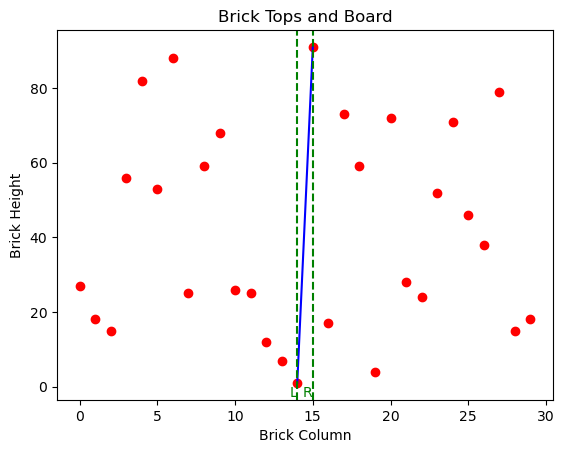

Left side changed


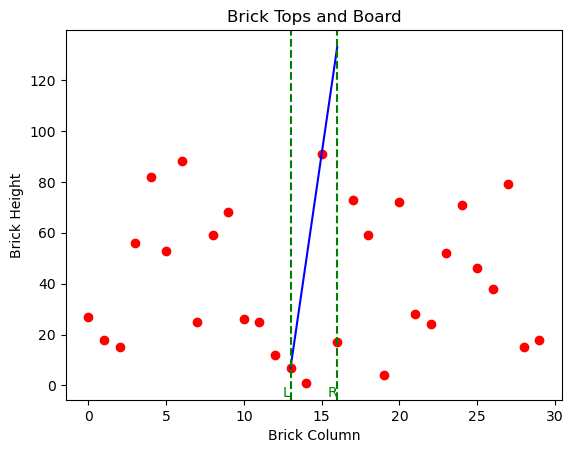

Left side changed


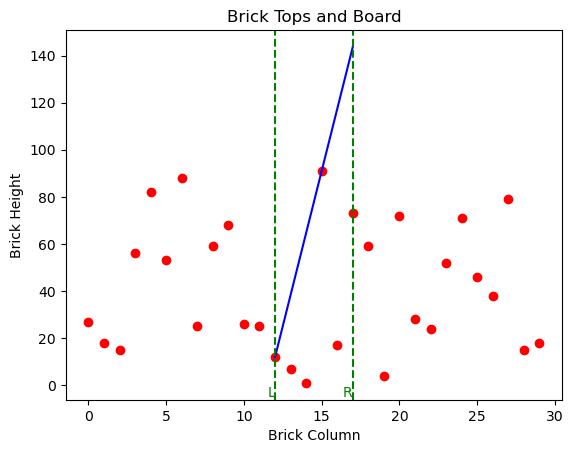

Left side changed


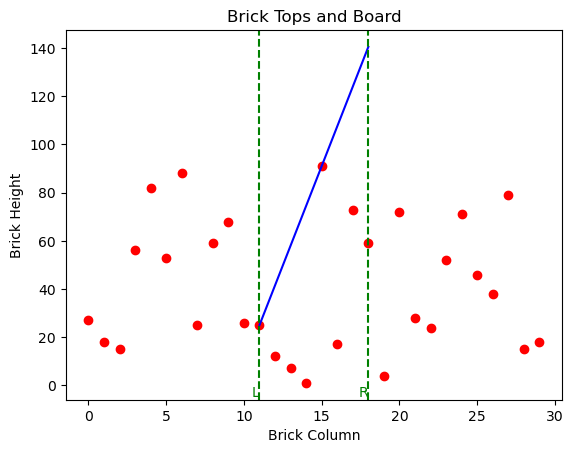

Left side changed


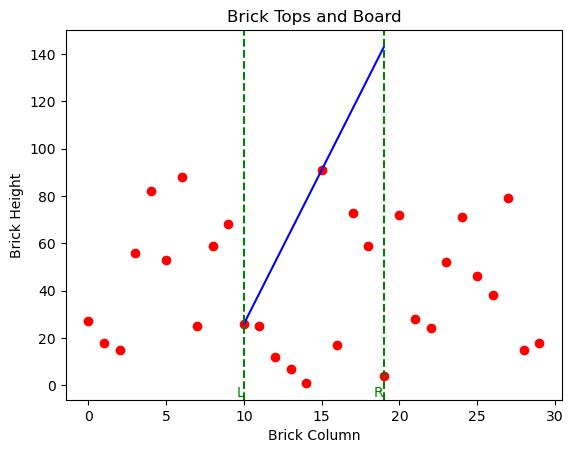

Left side changed


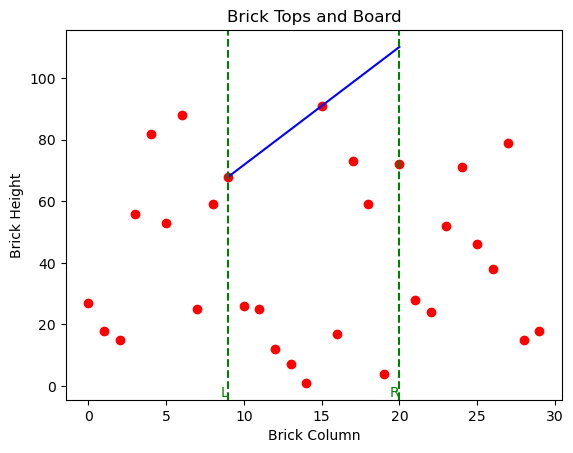

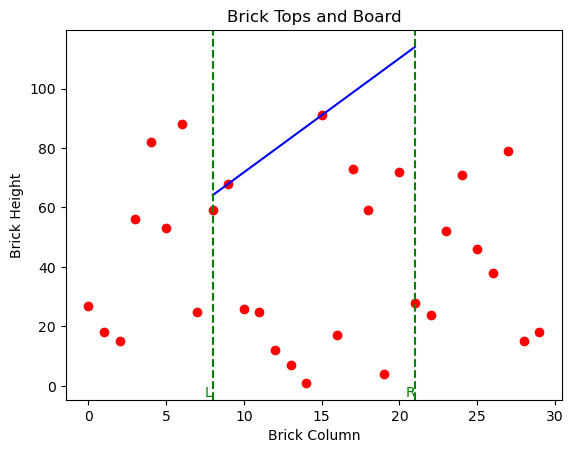

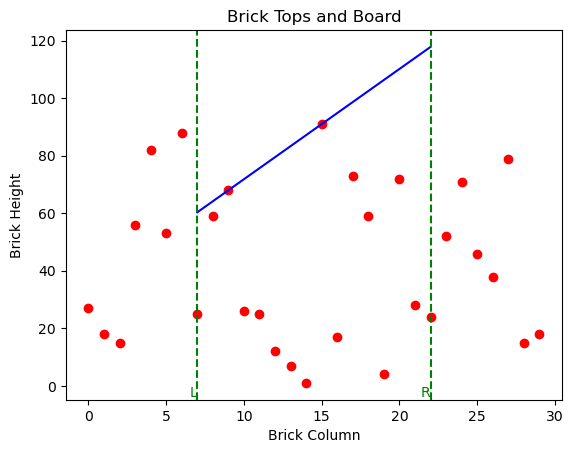

Left side changed


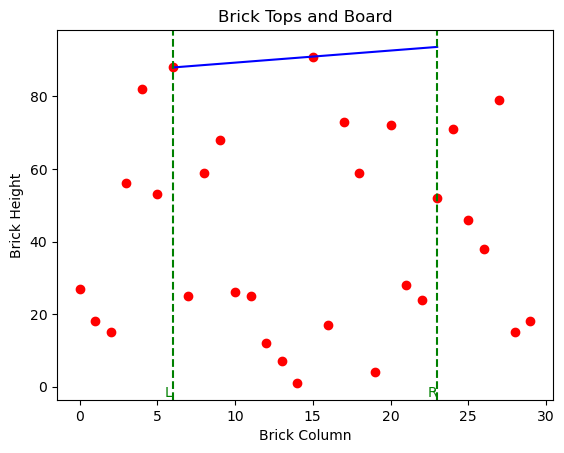

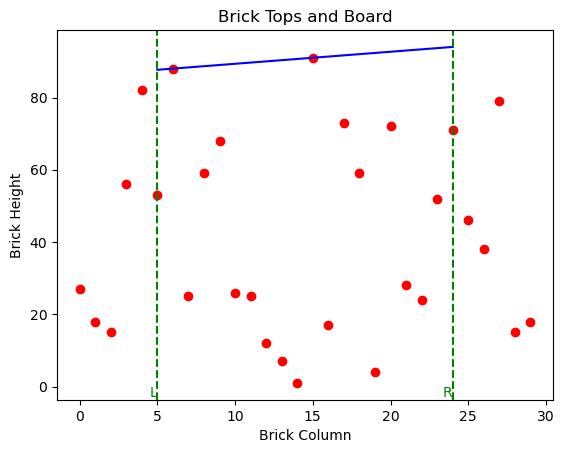

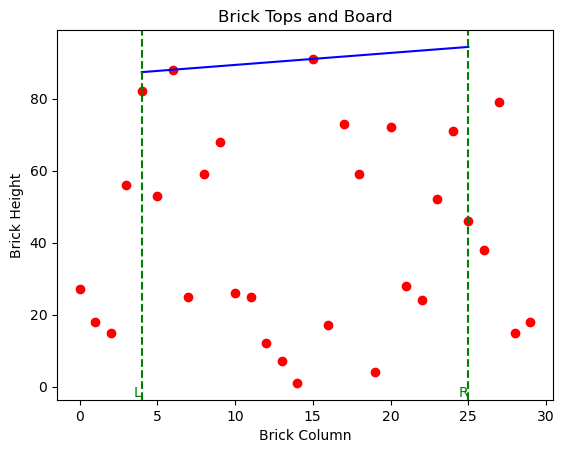

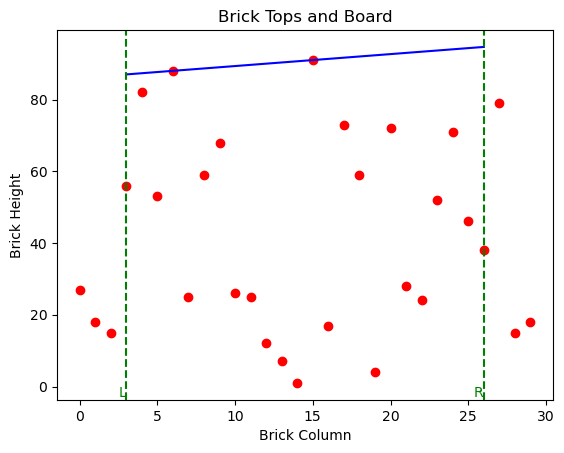

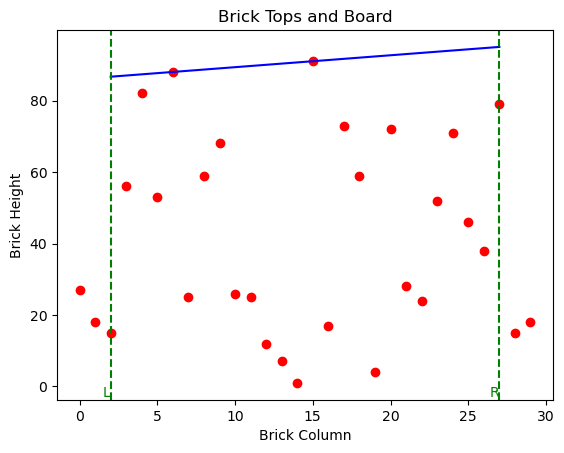

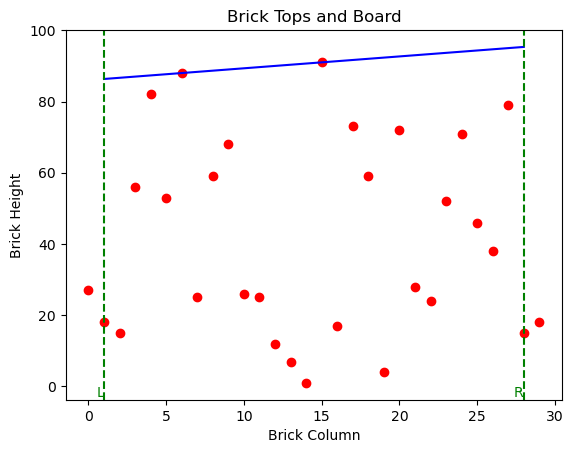

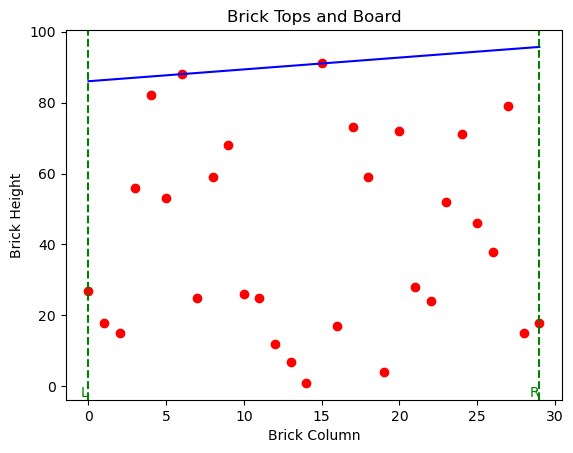

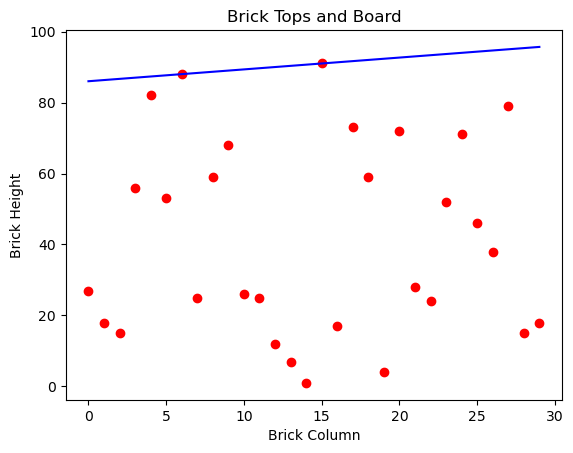

Data: [27, 18, 15, 56, 82, 53, 88, 25, 59, 68, 26, 25, 12, 7, 1, 91, 17, 73, 59, 4, 72, 28, 24, 52, 71, 46, 38, 79, 15, 18]
Slope: 0.3333333333333333
Y-Intercept: 86.0


In [16]:
# Calling the functions to visualize the output
data_length = 30
random_array = np.array([27, 18, 15, 56, 82, 53, 88, 25, 59, 68, 26, 25, 12, 7, 1, 91, 17, 73, 59, 4, 72, 28, 24, 52, 71, 46, 38, 79, 15, 18]) #generate_random_array(data_length)
slope, y_intercept = calculate_slope_intercept(random_array, True)
plot_data_with_line(random_array, slope, y_intercept)
print("Data:", json.dumps(random_array.tolist()))
print("Slope:", slope)
print("Y-Intercept:", y_intercept)

## Test it

Run the following code block to test your solution's accuracy. We'll run it 1000 times and check to make sure all the dots are on or under the line, and the line isn't defying gravity.

In [17]:
def print_fail(num, arr, slope, y_intercept, err):
    print(f"Test {num + 1} failed!")
    print(err)
    plot_data_with_line(arr, slope, y_intercept)
    print("Data:", json.dumps(arr.tolist()))
    print("Slope:", slope)
    print("Y-Intercept:", y_intercept)

errored = False
error_margin = 0.0000000000001
for i in range(0, 1):
    arr = np.array([27, 18, 15, 56, 82, 53, 88, 25, 59, 68, 26, 25, 12, 7, 1, 91, 17, 73, 59, 4, 72, 28, 24, 52, 71, 46, 38, 79, 15, 18]) #generate_random_array(30)
    slope, y_intercept = calculate_slope_intercept(arr)
    left_touch = False
    right_touch = False
    # Make sure all the points in arr are on or beneath the line
    for x, y in enumerate(arr):
        if y > slope * x + y_intercept + error_margin:
            print_fail(i, arr, slope, y_intercept, f"Point ({x},{y}) is above the line")
            errored = True
            break
        # Set touch to True if we find a point on the line
        if y > slope * x + y_intercept - error_margin:
            if x < len(arr) / 2:
                left_touch = True
            else:
                right_touch = True
    if not errored and not (left_touch and right_touch):
        print_fail(i, arr, slope, y_intercept, "The board is defying gravity!")
        errored = True
    if errored: break

if not errored: print("All tests passed!")

All tests passed!


Text(0, 0.5, 'Time Taken')

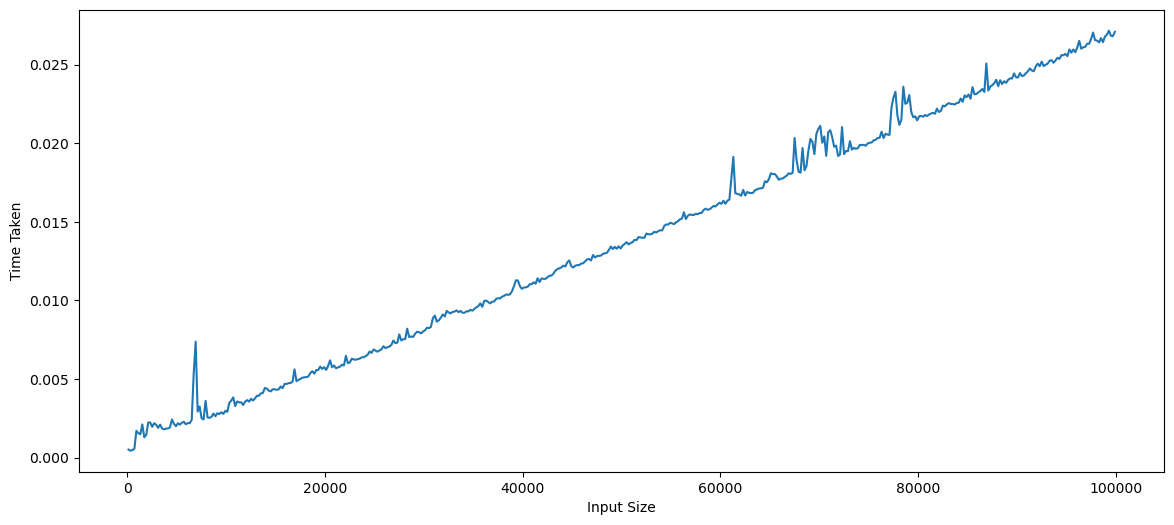

In [18]:
import time

input_sizes = range(100, 100000, 200)
samples = 1
times = []
for n in input_sizes:
    total = 0
    for j in range(samples):
        start_time = time.time()
        random_array = generate_random_array(n)
        slope, y_intercept = calculate_slope_intercept(random_array)
        end_time = time.time()
        total += (end_time - start_time)
    times.append(total / samples)

plt.figure(figsize=(14, 6))
plt.plot(input_sizes, times)
plt.xlabel('Input Size')
plt.ylabel('Time Taken')